In [1]:
import numpy as np
import scipy
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.covariance import shrunk_covariance
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pylab import mpl

import geomstats.geometry.spd_matrices as spd
from geomstats.geometry.spd_matrices import SPDAffineMetric
from geomstats.learning.preprocessing import ToTangentSpace
from sklearn.pipeline import Pipeline

import dill
import os

from utils.generate_and_plot_signals import generate_signals, plot_signals, plot_source_signals, find_value_index
from utils import draw_states, ttest_for_clusters
from utils.calc_fun import calc_diff

os.environ["OMP_NUM_THREADS"] = "4"

INFO: Using numpy backend


In [2]:
plt.rcParams['font.family']=['Arial', 'Times New Roman']
plt.style.use('default')
mpl.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'svg'

font = {'family':['Arial', 'Times New Roman'], 'color':'k', 'weight':'normal', 'size':10 }
colors = sns.color_palette('tab10')

# Generate or load data

In [3]:
# generate 50 random trials

n_trials = 50
n_ch = 6
n_times = 1001

raw_data = np.empty((n_trials, n_ch, n_times))
Atrue = np.random.random([n_ch, n_ch])

for t in range(n_trials):
    Strue = generate_signals(stationary=False)
    raw_data[t] = Atrue.dot(Strue)

X = raw_data[0]

# with open('./saves/generate_data.pkl', 'wb') as f:
#     dill.dump([Strue, Atrue, raw_data], f)

In [4]:
with open('./saves/generate_data.pkl', 'rb') as f:
    [Strue, Atrue, raw_data] = dill.load(f)

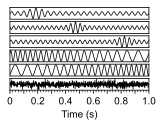

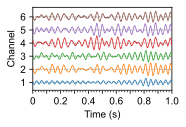

In [5]:
plot_signals(Strue, figsize=(2.5, 1.5));
plot_source_signals(raw_data[0], figsize=(2.5, 1.5));

# Calculate spatial covariance matrix

In [6]:
times = raw_data.shape[2]
chs = raw_data.shape[1]
lag_num = 200
half_lag = int(lag_num*0.5)
len_t = times-lag_num

avg_data = np.mean(raw_data, axis=0)
crop_eeg = np.zeros((chs, len_t))

Cov_mat = np.empty((len_t, chs, chs))
Cov_uptri = np.empty(( len_t, int(chs*((chs+1)/2)) ))

index = 0
for t in range(half_lag, len_t+half_lag):
    crop_eeg[:, index] = avg_data[:, t]

    # calculate covariance
    cov = np.cov(avg_data[:, t-half_lag:t+half_lag]) 
    cov = shrunk_covariance(cov, shrinkage=0.01)
    Cov_mat[index] = cov
    Cov_uptri[index] = cov[np.triu_indices(cov.shape[0], k=0)]
    index += 1

Cov_uptri.shape

(801, 21)

# Convert covariance matrices onto tangent space

In [7]:
dim = 6
manifold = spd.SPDMatrices(dim)
manifold.equip_with_metric(SPDAffineMetric)

pipeline = Pipeline([
    ("tangent_vec", ToTangentSpace(space=manifold))
])

tang_vec = pipeline.fit_transform(Cov_mat)

print(tang_vec.shape)

(801, 21)


# T-SNE visualization

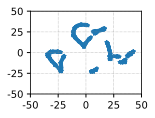

In [8]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

tsne_2d = tsne.fit_transform(tang_vec)    

fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
axi1.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
            marker='*', s=10, color=sns.color_palette('Paired')[1],
            )

ax = plt.gca()
plt.xlim([-50, 50])
plt.ylim([-50, 50])
plt.grid(True, linewidth=0.5, color='gray', linestyle=':')

plt.yticks([-50,-25,0,25,50],[-50,-25,0,25,50])
plt.xticks([-50,-25,0,25,50],[-50,-25,0,25,50])

ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
            labelbottom=True, labelleft=True, direction='out',width=1)
plt.show()

# K-Means clustering

In [9]:
num_clusters = [3,5,7]

pred_labels = np.empty( (len(num_clusters), tang_vec.shape[0]) )
pred_center = []

for i, n_c in enumerate(num_clusters):
    cluster = KMeans(n_clusters=n_c, random_state=0, n_init=10*n_c).fit(tang_vec)

    centroid = cluster.cluster_centers_ # [n_clusters, n_chs]
    pred_center.append(centroid)
    pred_labels[i] = cluster.labels_

pred_labels += 1

# T-SNE visualization

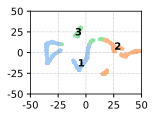

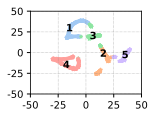

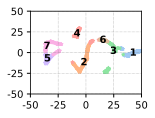

In [10]:
colors = sns.color_palette('pastel')

for ind, n_c in enumerate(num_clusters): 

    tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

    lf_with_center = np.vstack((tang_vec, pred_center[ind]))

    kmeans_2d_with_center = tsne.fit_transform(lf_with_center)    
    kmeans_2d = kmeans_2d_with_center[:-n_c, :]
    kmeans_2d_center = kmeans_2d_with_center[-n_c:, :]

    fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
    for i in range(n_c):
        axi1.scatter(kmeans_2d[pred_labels[ind] == i+1, 0], 
                     kmeans_2d[pred_labels[ind] == i+1, 1],
                     marker='*',
                     s=10,
                     color=colors[i],
                    )
        axi1.text(kmeans_2d_center[i,0], kmeans_2d_center[i,1], 
                  i+1, fontsize=10, fontweight='semibold', 
                  verticalalignment='center', horizontalalignment='center', 
                  color='black', 
                )

    ax = plt.gca()
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plt.grid(True, linewidth=0.5, color='gray', linestyle=':')

    plt.yticks([-50,-25,0,25,50],[-50,-25,0,25,50])
    plt.xticks([-50,-25,0,25,50],[-50,-25,0,25,50])

    ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True, direction='out',width=1)
    plt.show()

# Plot microstate series

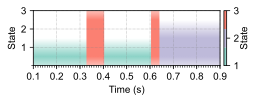

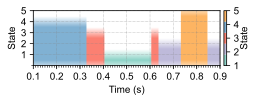

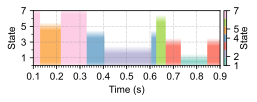

In [11]:
for n_c in range(len(num_clusters)):
    draw_states.draw_state_blocks_for_generated_data(pred_labels[n_c], figsize=(3.5, 1.0), 
                                                     n_clusters=int(np.max(pred_labels[n_c])),
                                                     colorbar_fraction=0.015, tmin=0.1, tmax=0.9, 
                                                     colorbar_ticks=[]);

# t-test of clustering results

## Calculate Riemann distance

In [12]:
tp = Cov_mat.shape[0]

cov_dist_uptri = np.full((tp, tp), np.nan)
cov_dist = np.ones((tp, tp))

for i in range(tp):
    for j in range(i+1, tp):        
        cov1 = Cov_mat[i]
        cov2 = Cov_mat[j]

        # riemann_dist = manifold.metric.dist(cov1, cov2)  # too slow 
        
        d2 = (np.log(scipy.linalg.eigvalsh(cov1,cov2))**2).sum(axis=-1)
        riemann_dist = np.sqrt(d2)

        cov_dist_uptri[i,j] = riemann_dist
        cov_dist[i,j] = riemann_dist
        cov_dist[j,i] = riemann_dist

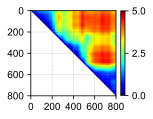

In [13]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(cov_dist_uptri, interpolation='none', vmin=0.0, vmax=5.0, cmap='jet'); 
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 2.5, 5])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
clb.ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(0,801,200), np.arange(0,801,200), fontdict=font);
ax.set_yticks(np.arange(0,801,200), np.arange(0,801,200), fontdict=font);
plt.show();


[]


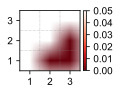

[]


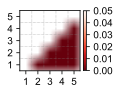

[]


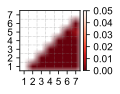

In [14]:
for n_c in range(len(num_clusters)):
    p_res = ttest_for_clusters.distance_ttest(pred_labels[n_c], cov_dist, samp_num=500)
    ttest_for_clusters.draw_test_mat(p_res, corr_p=True)

# Calculate errors

In [15]:
for i in range(3):
    # SSE, Distance, CH_Score, SI_Score, DB_Score
    values = calc_diff(crop_eeg.T, pred_labels[i])
    print(values)

(139.10139258641857, 11.794125342153125, 0.3689336419545825, -0.11108190916255944, 66.59175182964627)
(138.6691117055219, 11.775784971946537, 0.8049317966772837, -0.12110814739019414, 30.665091830283224)
(133.89355810313106, 11.571238399718979, 5.274269761324863, -0.1254007900060094, 23.640182532205106)
